## Adjust D3D grid 

This is the prototype for adjusting the grid to conform with Natural Earth coastlines.

In [35]:
#to use the full width of the browser window uncomment the code below and execute the cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import sys
from PIL import Image
import matplotlib.path as mpltPath
import pyresample
import geopandas as gp
from pyPoseidon.dem import *
from shapely import geometry, ops
import pandas as pd

In [2]:
%matplotlib notebook

In [3]:
#Define the lat/lon window of interest
dic = {'minlon':-35., # lat/lon window
       'maxlon':43.,
       'minlat':24.5,
       'maxlat':76.5,
       'dpath':'/Users/brey/DATA/GEBCO_2014_2D.nc'}

In [4]:
dic = {'minlon' : -10, # lat/lon window
       'maxlon' : 5.,
       'minlat' : 50.,
       'maxlat' : 59.,
       'dpath':'/Users/brey/DATA/GEBCO_2014_2D.nc'}

In [5]:
dic = {'minlon':-4.2, # lat/lon window
     'maxlon':35.,
     'minlat':31.,
     'maxlat':47.5,
       'dpath':'/Users/brey/DATA/GEBCO_2014_2D.nc'}

In [6]:
## Create a grid 
resolution = .1
lon=np.arange(dic['minlon'],dic['maxlon'],resolution)
lat=np.arange(dic['minlat'],dic['maxlat'],resolution)
xp, yp = np.meshgrid(lon,lat)

In [7]:
dic.update({'grid_x':xp, 'grid_y':yp}) #add grid to the dictionary

In [8]:
points=zip(xp.flatten(),yp.flatten()) #make a list of all points of grid

In [9]:
#helper function
def get_key(item):
    return item[1]

In [10]:
#object to use a different coastline is Basemap graphs
class Basemap(Basemap):
    """ Modify Basemap to use Natural Earth data instead of GSHHG data """
    def drawcoastlines(self):
        shapefile = '/Users/brey/DATA/COASTLINES/naturalearth/coastline/ne_%sm_coastline' % \
                    {'l':110, 'i':50, 'h':10}[self.resolution]
        self.readshapefile(shapefile, 'coastline', linewidth=1.)
#    def drawcountries(self):
#        shapefile = '/Users/brey/Downloads/data/naturalearth/countries/ne_%sm_admin_0_countries' % \
#                    {'l':110, 'm':50, 'h':10}[self.resolution]
#        self.readshapefile(shapefile, 'countries', linewidth=0.5)



## Analysis

In [11]:
#Define the coastline shapefile
shapefile = '/Users/brey/DATA/COASTLINES/naturalearth/coastline/ne_%sm_coastline' % \
                    {'l':110, 'i':50, 'h':10}['i']

In [12]:
#read it into a DataFrame
shp = gp.GeoDataFrame.from_file(shapefile+'.shp')


In [13]:
shp['length']=shp['geometry'][:].length # optional

In [14]:
shp = shp.sort_values(by='length', ascending=0) #optional
shp = shp.reset_index(drop=True)

In [15]:
#put all Lines in a list
ls=[]
for i in range(shp.shape[0]):
    il = shp.loc[i,'geometry']
    try:
        print len(il)
        for k in range(len(list(il.geoms))):
               ls.append(list(il.geoms)[k])
    except:
        ls.append(il)

2


In [16]:
len(ls) # number of lines

1429

In [17]:
shp.iloc[0]

scalerank                                                     0
featurecla                                            Coastline
geometry      (LINESTRING (54.71005859375001 40.89111328125,...
length                                                  1673.69
Name: 0, dtype: object

In [18]:
sall = geometry.MultiLineString(ls) #join them into a Multiline

In [19]:
c = ops.linemerge(sall) #merge parts if possible

In [20]:
len(c) #number of Lines after merging

1422

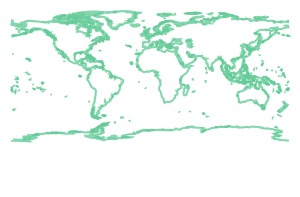

In [21]:
c #visualize

## Select the Line Strings that correspond to our grid

In [22]:
#create a polygon of the grid
grp=geometry.Polygon([(lon.min(),lat.min()),(lon.min(),lat.max()),(lon.max(),lat.max()),(lon.max(),lat.min())])

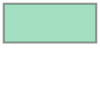

In [23]:
grp

In [24]:
cl=[] #initialize
#add Polygons if they intersect with the grid
for i in range(len(c)):
    z = geometry.Polygon(c[i])
    if z.intersects(grp): 
            cl.append(c[i])

In [25]:
len(cl)

71

In [26]:
cll = geometry.MultiLineString(cl) #join them into a Multiline

In [27]:
cg = ops.linemerge(cll) #merge parts if possible

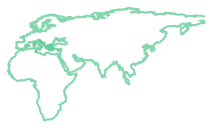

In [28]:
cg

In [29]:
len(cg)

71

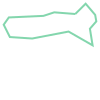

In [30]:
cg[10]

Check which points of the grid are inside the shoreline. Since the shoreline is fragmented in a number of lines (e.g. islands) there will be a number of datasets (members of the full set of points) defined. We add them to a list of lists.

In [31]:
#%%timeit
#check if the grid polygons intersect the shoreline
gps = []
igps = []
for i in range(0,xp.shape[0]-1):
    for j in range(0,xp.shape[1]-1):
        p = geometry.Polygon([(xp[i,j],yp[i,j]),(xp[i+1,j],yp[i+1,j]),(xp[i+1,j+1],yp[i+1,j+1]),(xp[i,j+1],yp[i,j+1])])
        if not p.intersects(cg): 
            gps.append(p)
            igps.append([i+1,j+1])
            if i == 0 : 
                igps.append([i,j])
                igps.append([i,j+1])
            if j == 0 : 
                igps.append([i,j])
                igps.append([i+1,j])

In [32]:
len(igps)

61735

In [33]:
#create a mask of all cells not intersecting the shoreline
imask=np.ones(xp.shape, dtype=bool)
for [i,j] in igps:
    imask[i,j]=0

In [228]:
### visualize on image
#im = Image.fromarray(np.flipud(imask).astype('uint8')*255)
#im.show()

In [34]:
#valid grid points away from coastline
vx=np.ma.masked_array(xp,imask)
vy=np.ma.masked_array(yp,imask)

<IPython.core.display.Javascript object>


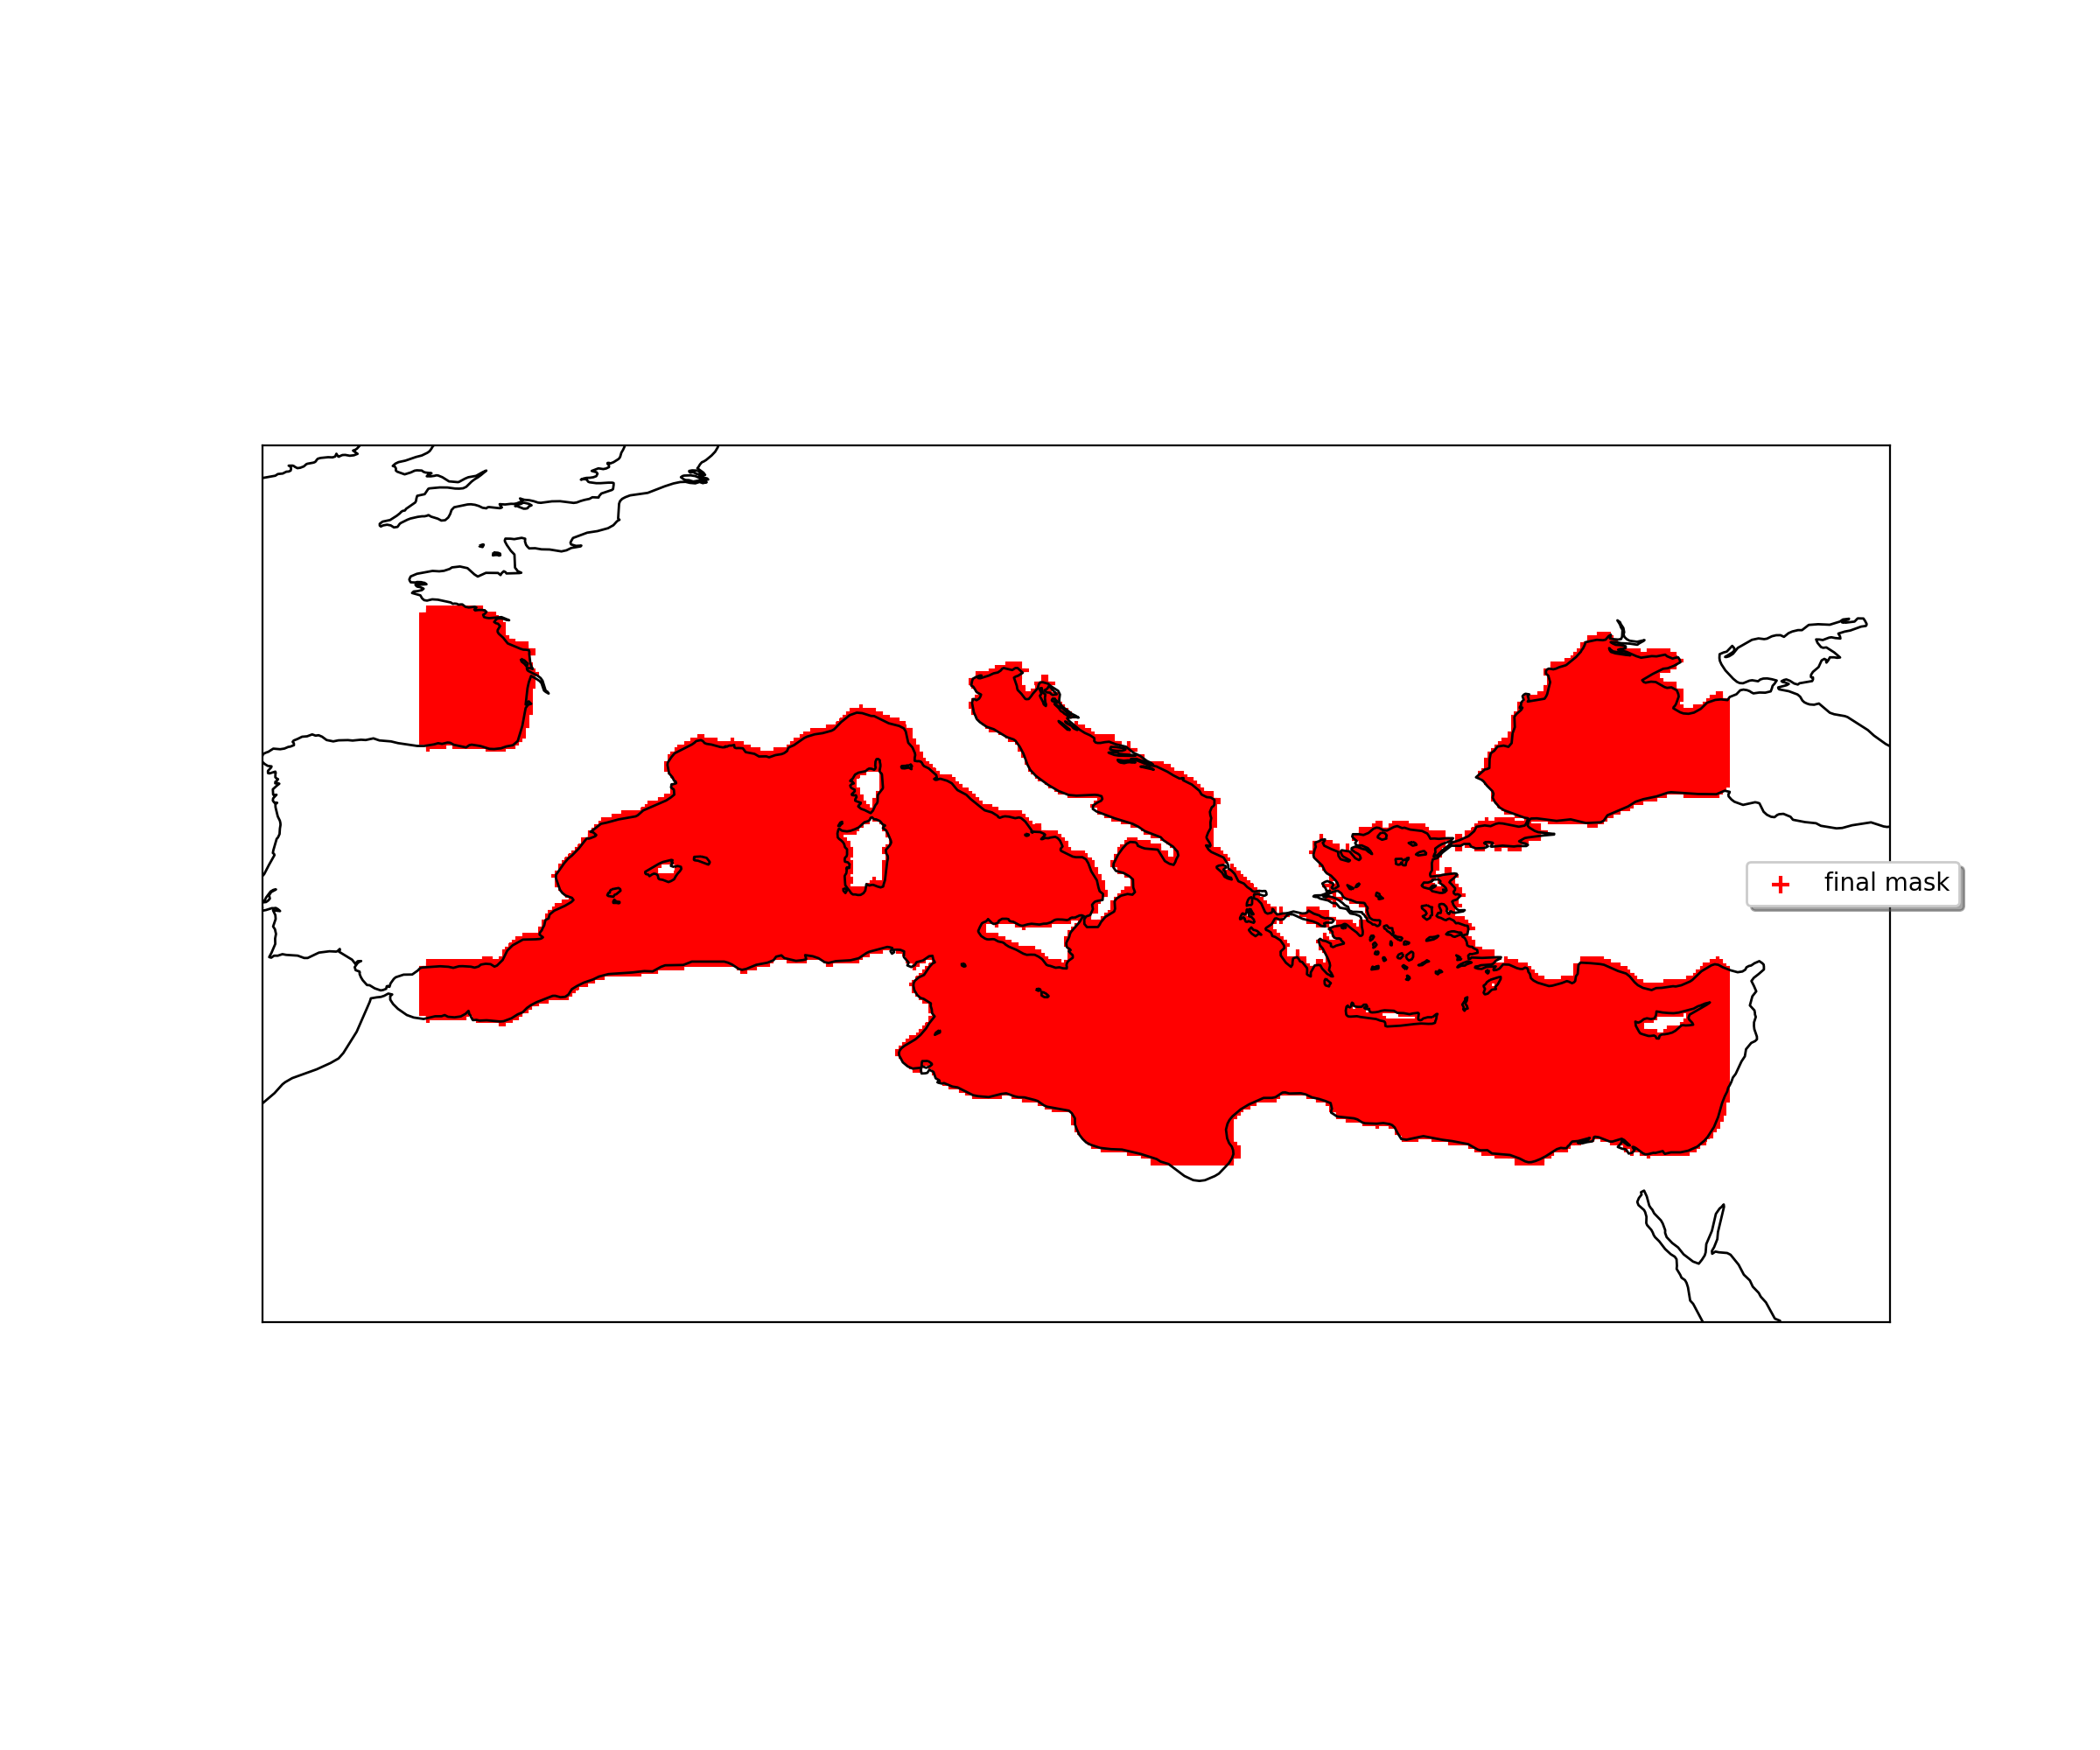

In [38]:
plt.figure(num='Valid grid points',figsize=(12,10))
m = Basemap(llcrnrlon=dic['minlon']-5., llcrnrlat=dic['minlat']-5., urcrnrlon=dic['maxlon']+5., urcrnrlat=dic['maxlat']+5.,
            resolution='i')  # resolution = (l)ow | (i)intermediate | (h)igh
m.drawcoastlines()
#m.drawcountries()

In [378]:
m.scatter(vx,vy,color='y',marker='x', s=10, label='valid points')
plt.legend(loc='center right', bbox_to_anchor=(1.15, .5),
          fancybox=True, shadow=True)

## Find points inside coastline (land) 

In [35]:
xi=[]
yi=[]
for i in range(len(cg)):
    z = geometry.Polygon(cg[i])
    path = mpltPath.Path(zip(z.boundary.xy[0],z.boundary.xy[1]))

    inside = path.contains_points(points)

    if np.sum(inside) > 0:
        X = np.ma.masked_array(xp,mask=np.invert(inside)),
        Y = np.ma.masked_array(yp,mask=np.invert(inside))
        xi.append(X)
        yi.append(Y)
       # m.scatter(X,Y,color='g',marker='+')

In [36]:
#merge all the masks into one
lmask=np.ones(xi[0][0].shape, dtype=bool)
for i in range(len(xi)):
    lmask = np.logical_and(lmask,xi[i][0].mask)

In [ ]:
#land grid points (dry points)
landx=np.ma.masked_array(xp,lmask)
landy=np.ma.masked_array(yp,lmask)


m.scatter(landx,landy,color='brown',marker='o', s=105 ,facecolors='none', edgecolors='brown', label='dry points')
plt.legend(loc='center right', bbox_to_anchor=(1.05, .5),
        fancybox=True, shadow=True)

In [322]:
#water grid points (bathymetry points)
waterx=np.ma.masked_array(xp,np.invert(lmask))
watery=np.ma.masked_array(yp,np.invert(lmask))


m.scatter(waterx,watery,color='b',marker='o', s=105 ,facecolors='none', edgecolors='b',label='wet points')
plt.legend(loc='center right', bbox_to_anchor=(1.05, .5),
        fancybox=True, shadow=True)

## Join Valid and Sea masks

In [39]:
tmask = np.logical_and(np.invert(imask),lmask)
tmask = np.invert(tmask)

In [40]:
#water grid points (bathymetry points)
wx=np.ma.masked_array(xp,tmask)
wy=np.ma.masked_array(yp,tmask)


m.scatter(wx,wy,color='r',marker='+', s=50, label='final mask')
plt.legend(loc='center right', bbox_to_anchor=(1.05, .5),
        fancybox=True, shadow=True)

### Visualize total mask as an image

In [41]:
im = Image.fromarray(np.flipud(tmask).astype('uint8')*255) # note the up/down flip for adjusting to Image function requirements
im.show()

Note the creation of white islands (if present) indicate discontinuity of the grid in terms of water. These can not be left in because they create instabilities and are in fact unphysical. We need to retain only the biggest continuous volume of water.

In [42]:
np.savez('/Users/brey/Downloads/water',tmask) #optional for future use

## Fix islands 

In [45]:
qmask = tmask.copy()

In [46]:
from collections import deque

b = [[0, 1], [1, 0]], [[0, 1], [-1, 0]], [[0, -1], [1, 0]], [[0, -1], [-1, 0]]    



class Solution(object):
    def append_if(self, queue, x, y, island_counter):
        """Append to the queue only if in bounds of the grid and the cell value is 1."""
        if 0 <= x < len(self.grid) and 0 <= y < len(self.grid[0]):
            if self.grid[x][y] == '1':
#                queue.append((x, y))
                for [i,j],[k,l] in b:
                    try:
                        if self.grid[x+i][y+j] in ['1', island_counter] and self.grid[x+k][y+l] in ['1', island_counter]:
                            queue.append((x, y))
                            break
                    except:pass
                

    def mark_neighbors(self, row, col, island_counter):
        """Mark all the cells in the current island with value = 2. Breadth-first search."""
        queue = deque()

        queue.append((row, col))
        while queue:
            x, y = queue.pop()
            self.grid[x][y] = island_counter

            self.append_if(queue, x - 1, y, island_counter)
            self.append_if(queue, x, y - 1, island_counter)
            self.append_if(queue, x + 1, y, island_counter)
            self.append_if(queue, x, y + 1, island_counter)
     #       self.append_if(queue, x - 1, y - 1)
     #       self.append_if(queue, x + 1, y - 1)
     #       self.append_if(queue, x + 1, y + 1)
     #       self.append_if(queue, x - 1, y + 1)


            
    def numIslands(self, grid):
        """
        :type grid: List[List[str]]
        :rtype: int
        """

        if not grid or len(grid) == 0 or len(grid[0]) == 0:
            return 0

        self.grid = grid

        row_length = len(grid)
        col_length = len(grid[0])

        island_counter = 0
        for row in range(row_length):
            for col in range(col_length):
                if self.grid[row][col] == '1':
                    # found an island
                    island_counter += 1

                    self.mark_neighbors(row, col, island_counter)

        return island_counter



In [47]:
grid = np.invert(qmask).astype(int).astype(str)
grid = [list(x) for x in grid]
isls = Solution().numIslands(grid)
print(isls)



133


In [48]:
mgrid = np.array(grid).astype(int)

In [49]:
nps = []
for i in range(1, isls + 1):
    nps.append(np.sum(mgrid != i))
    

In [50]:
mgrid.size

64680

In [51]:
grs = pd.DataFrame([(val, idx) for (idx, val) in enumerate(nps)],columns=['val','idx'])

In [52]:
grs.head()

,val,idx
0,41318,0
1,64679,1
2,64679,2
3,64679,3
4,64679,4


In [53]:
grs = grs.sort_values('val').reset_index(drop=True)

In [54]:
grs.head()

,val,idx
0,41318,0
1,62169,105
2,63599,115
3,64606,92
4,64672,23


In [55]:
grs['np']=mgrid.size-grs.val # count number of points in islands

In [56]:
grs.head()

,val,idx,np
0,41318,0,23362
1,62169,105,2511
2,63599,115,1081
3,64606,92,74
4,64672,23,8


In [57]:
nc = 20 # number of cells for island consideration

In [58]:
ne = grs[grs.np>nc].index.max() + 1

In [59]:
ne

4

In [67]:
#b = mgrid.copy()
#vwater = np.ma.masked_array(b, b != grs.loc[1,'idx']+1)
#vwater[np.invert(vwater.mask)] = 1    

#XW = np.ma.masked_array(xp,vwater.mask) #get wet points 
#YW = np.ma.masked_array(yp,vwater.mask)
#XC = np.ma.masked_array(xp,np.invert(vwater.mask)) #get dry points by inverting the wet mask
#YC = np.ma.masked_array(yp,np.invert(vwater.mask))

#plt.figure(figsize=(16,12))
#m = Basemap(llcrnrlon=dic['minlon'], llcrnrlat=dic['minlat'], urcrnrlon=dic['maxlon'], urcrnrlat=dic['maxlat'],
#            resolution='i')  # resolution = (l)ow | (i)intermediate | (h)igh
#m.drawcoastlines()
#m.drawcountries()

#m.scatter(XC,YC,color='r',marker='o') #plot dry

#m.scatter(XW,YW,color='b',marker='o') #plot wet

### Merge all big water areas

In [60]:
mask={}
for i in range(ne):
    b = mgrid.copy()
    vm = np.ma.masked_array(b, b != grs.loc[i,'idx']+1)
    vm[np.invert(vm.mask)] = 1    
    mask.update({str(i):vm})

In [61]:
fmask=np.zeros(xp.shape, dtype=bool) # initiate

In [62]:
#merge masks
for key, val in mask.iteritems():
    fmask = np.logical_xor(val.mask,fmask)

if ne % 2 == 0:    
    wmask = np.invert(fmask) # this is wet
else:
    wmask = fmask

In [63]:
XW = np.ma.masked_array(xp,wmask) #get wet points 
YW = np.ma.masked_array(yp,wmask)
XC = np.ma.masked_array(xp,np.invert(wmask)) #get dry points by inverting the wet mask
YC = np.ma.masked_array(yp,np.invert(wmask))

<IPython.core.display.Javascript object>


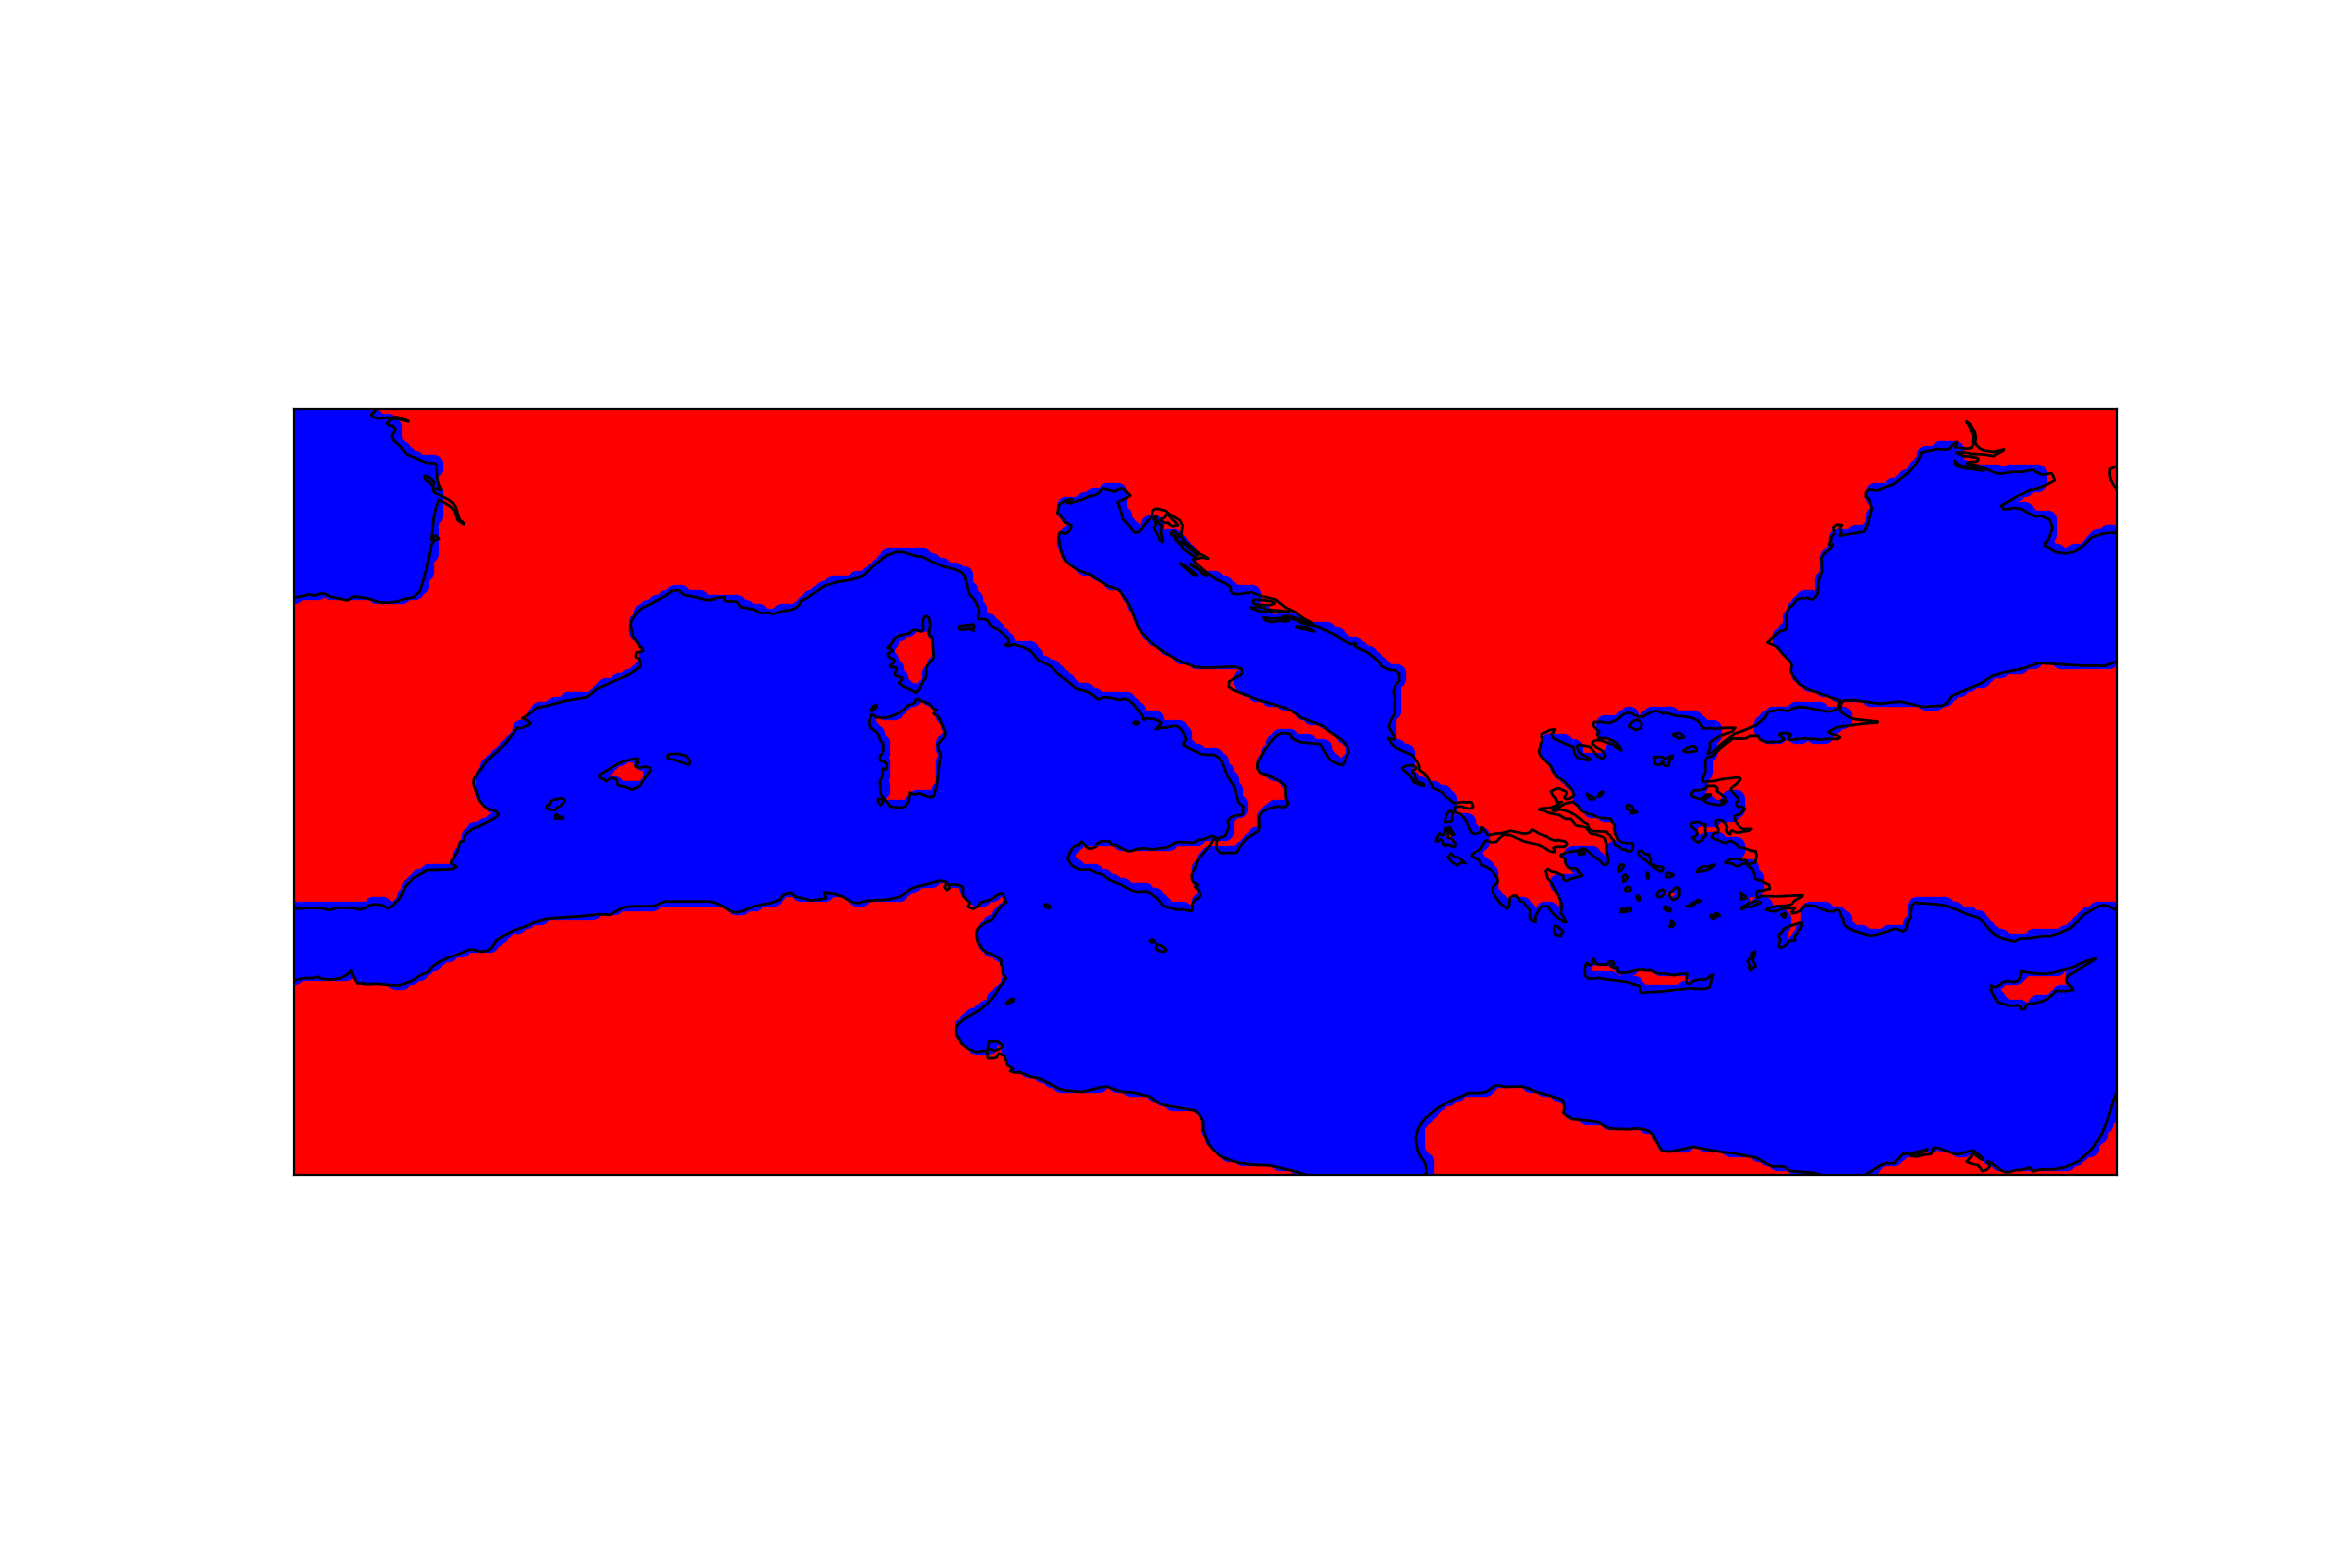

In [65]:
plt.figure(figsize=(12,8))
m = Basemap(llcrnrlon=dic['minlon'], llcrnrlat=dic['minlat'], urcrnrlon=dic['maxlon'], urcrnrlat=dic['maxlat'],
            resolution='i')  # resolution = (l)ow | (i)intermediate | (h)igh
m.drawcoastlines()
#m.drawcountries()

m.scatter(XC,YC,color='r',marker='o') #plot dry

m.scatter(XW,YW,color='b',marker='o') #plot wet

## Running it again through BFS to eliminate outliers

In [66]:
pmask = tmask.copy()

In [67]:
def rmt(imask,xp,nc):
    grid = np.invert(imask).astype(int).astype(str)
    grid = [list(x) for x in grid]
    isls = Solution().numIslands(grid)

    mgrid = np.array(grid).astype(int)
    nps = []
    for i in range(1, isls + 1):
        nps.append(np.sum(mgrid != i))
    
    grs = pd.DataFrame([(val, idx) for (idx, val) in enumerate(nps)],columns=['val','idx'])

    grs = grs.sort_values('val').reset_index(drop=True)
    
    grs['np']=mgrid.size-grs.val # count number of points in islands
    
    ne = grs[grs.np>nc].index.max() + 1
    
    mask={}
    for i in range(ne):
        b = mgrid.copy()
        vm = np.ma.masked_array(b, b != grs.loc[i,'idx']+1)
        vm[np.invert(vm.mask)] = 1    
        mask.update({str(i):vm})

    fmask=np.zeros(xp.shape, dtype=bool) # initiate

#merge masks
    for key, val in mask.iteritems():
        fmask = np.logical_xor(val.mask,fmask)

    if ne % 2 == 0:    
        return np.invert(fmask) # this is wet
    else:
        return fmask


In [68]:
from collections import deque

b = [[0, 1], [1, 0]], [[0, 1], [-1, 0]], [[0, -1], [1, 0]], [[0, -1], [-1, 0]]    



class Solution(object):
    def append_if(self, queue, x, y, island_counter):
        """Append to the queue only if in bounds of the grid and the cell value is 1."""
        if 0 <= x < len(self.grid) and 0 <= y < len(self.grid[0]):
            if self.grid[x][y] == '1':
#                queue.append((x, y))
                for [i,j],[k,l] in b:
                    try:
                        if self.grid[x+i][y+j] in ['1', island_counter] and self.grid[x+k][y+l] in ['1', island_counter]:
                            queue.append((x, y))
                            break
                    except:pass
                

    def mark_neighbors(self, row, col, island_counter):
        """Mark all the cells in the current island with value = 2. Breadth-first search."""
        queue = deque()

        queue.append((row, col))
        while queue:
            x, y = queue.pop()
            self.grid[x][y] = island_counter

            self.append_if(queue, x - 1, y, island_counter)
            self.append_if(queue, x, y - 1, island_counter)
            self.append_if(queue, x + 1, y, island_counter)
            self.append_if(queue, x, y + 1, island_counter)
     #       self.append_if(queue, x - 1, y - 1)
     #       self.append_if(queue, x + 1, y - 1)
     #       self.append_if(queue, x + 1, y + 1)
     #       self.append_if(queue, x - 1, y + 1)


            
    def numIslands(self, grid):
        """
        :type grid: List[List[str]]
        :rtype: int
        """

        if not grid or len(grid) == 0 or len(grid[0]) == 0:
            return 0

        self.grid = grid

        row_length = len(grid)
        col_length = len(grid[0])

        island_counter = 0
        for row in range(row_length):
            for col in range(col_length):
                if self.grid[row][col] == '1':
                    # found an island
                    island_counter += 1

                    self.mark_neighbors(row, col, island_counter)

        return island_counter



In [69]:
p = rmt(pmask,xp,nc) 

In [70]:
# repeat until convergence
k=0
while True:
    p1 = rmt(p,xp,nc)
    k+=1
    print k
    if np.array_equal(p1,p) : break
    p = p1

1
2
3
4


In [71]:
nXW = np.ma.masked_array(xp,p1) #get wet points 
nYW = np.ma.masked_array(yp,p1)
nXC = np.ma.masked_array(xp,np.invert(p1)) #get dry points by inverting the wet mask
nYC = np.ma.masked_array(yp,np.invert(p1))

<IPython.core.display.Javascript object>


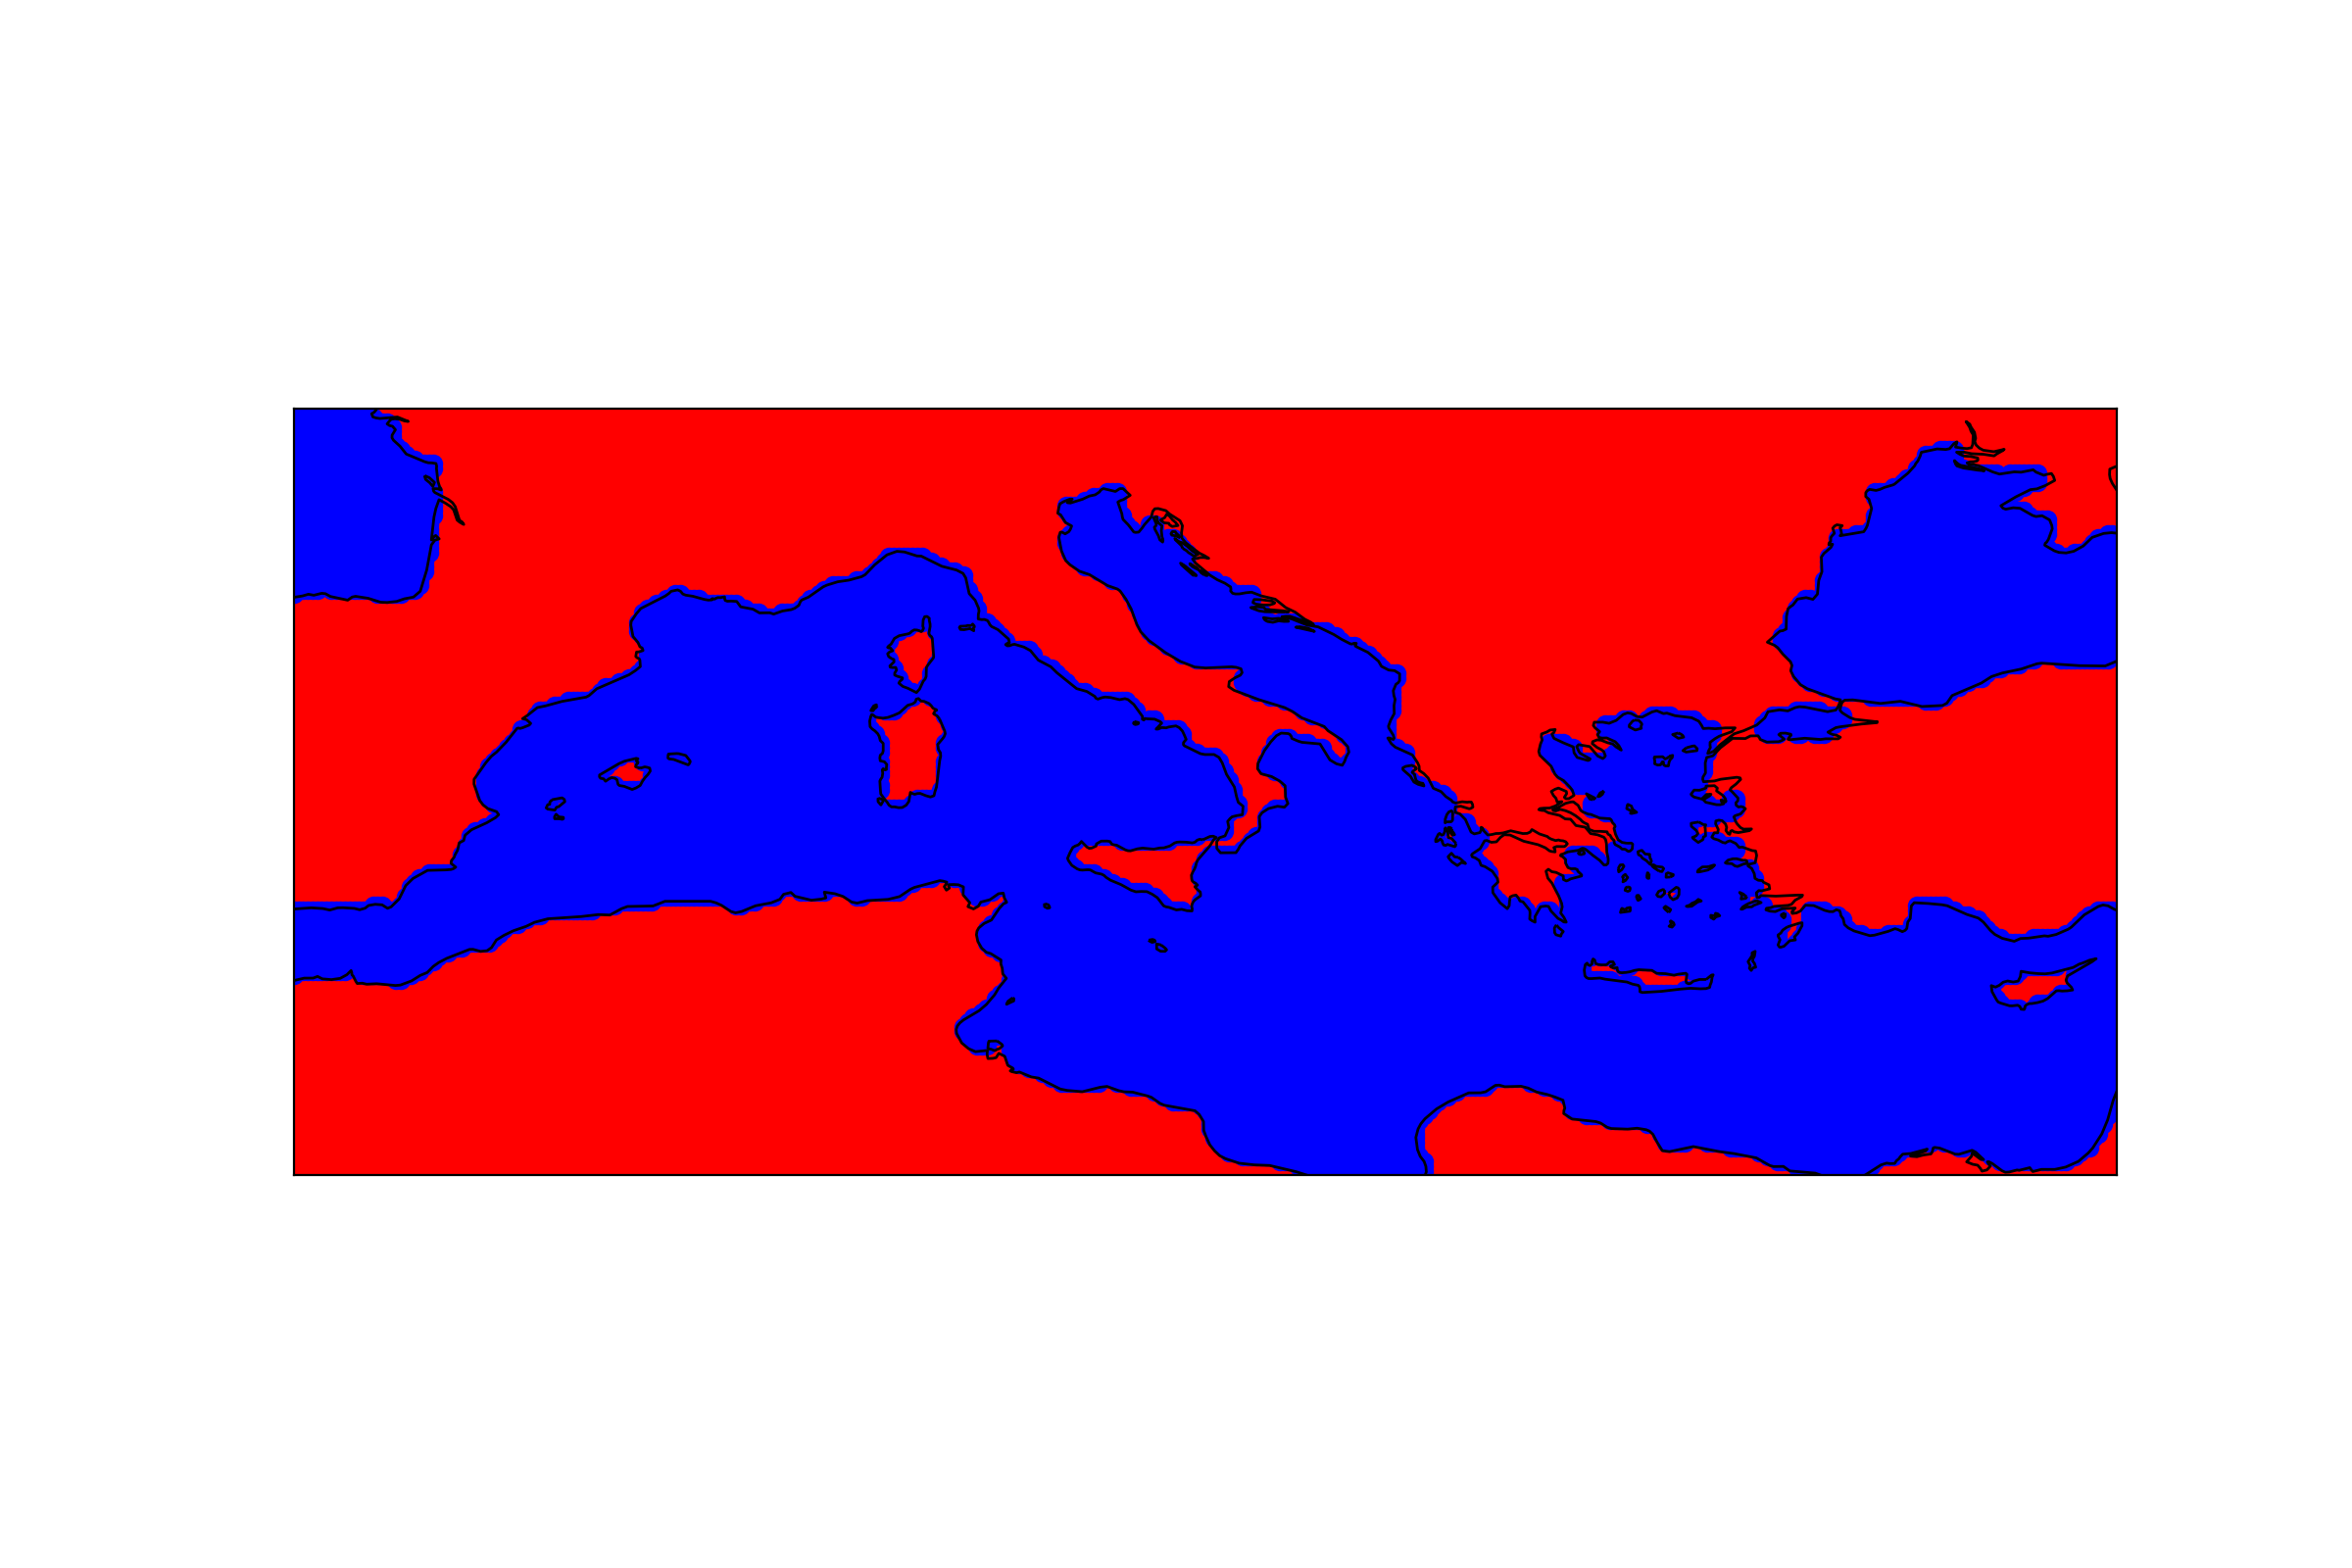

In [72]:
plt.figure(figsize=(12,8))
m = Basemap(llcrnrlon=dic['minlon'], llcrnrlat=dic['minlat'], urcrnrlon=dic['maxlon'], urcrnrlat=dic['maxlat'],
            resolution='i')  # resolution = (l)ow | (i)intermediate | (h)igh
m.drawcoastlines()
#m.drawcountries()
m.scatter(nXC,nYC,color='r',marker='o') #plot dry

m.scatter(nXW,nYW,color='b',marker='o') #plot wet